In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statistics import mean
from sklearn.model_selection import train_test_split

import numpy as np

import tensorflow as tf
from tensorflow import keras
from pylab import rcParams
import string
import re
import math
from matplotlib import rc
from sklearn.model_selection import train_test_split
from collections import Counter, defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.ticker as ticker
from math import sqrt


from sklearn.metrics import mean_squared_error

%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.3)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
NY_reviews = pd.read_csv('/content/drive/MyDrive/DS4A Team4/New_York_reviews_cleaned.csv', index_col=0)
NY_reviews.head()

,restaurant_name,rating_review,sample,title_review,review_preview,review_full,date,author_id
1,Lido,5,Positive,a regular treat,my wife and i have been eating dinner frequent...,my wife and i have been eating dinner frequent...,2020-10-08,UID_0
2,Lido,4,Positive,good neighborhood spot!,came with family for labor day weekend brunch ...,came with family for labor day weekend brunch ...,2020-09-08,UID_1
3,Lido,1,Negative,disappointing,food was mediocre at best. the lamb chops are...,food was mediocre at best. the lamb chops are ...,2020-02-17,UID_2
4,Lido,5,Positive,what a find in harlem,my co-workers were volunteering at a foodbank ...,my co-workers were volunteering at a foodbank ...,2019-11-25,UID_3
5,Lido,5,Positive,lunch,lido is an intimate boutique style restaurant....,lido is an intimate boutique style restaurant....,2019-11-23,UID_4


In [5]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

In [6]:
#check and aggregate the multiple reviews by one author for a single restaurant
grouped = NY_reviews.groupby(['author_id', 'restaurant_name'])

review_counts = grouped.size().reset_index(name='review_count')

review_avg = grouped['rating_review'].mean().reset_index(name='review_avg')

review_counts['avg_rating'] = review_avg['review_avg']

multi_review_list = review_counts.sort_values(by='review_count', ascending=False)

print(multi_review_list[multi_review_list['review_count']>1])

         author_id         restaurant_name  review_count  avg_rating
17592    UID_10761             Ess_a_Bagel            11    5.000000
338941     UID_438            P_J_Clarke_s            10    4.600000
437325   UID_76880           Comfort_Diner            10    5.000000
476335   UID_91316    Da_Marino_Restaurant            10    5.000000
247630   UID_23231    Wonton_Noodle_Garden             9    4.222222
...            ...                     ...           ...         ...
63299   UID_127903                Treehaus             2    3.000000
247799  UID_232443            Bodega_Negra             2    5.000000
129546  UID_161229     Blue_Smoke_Flatiron             2    5.000000
317091   UID_37510    Le_CouCou_Restaurant             2    5.000000
120422  UID_156355  John_s_of_Times_Square             2    5.000000

[11139 rows x 4 columns]


In [7]:
ratings = multi_review_list.pivot(index = 'author_id', columns = 'restaurant_name', values = 'avg_rating')

In [8]:
ratings = ratings.fillna(0).values

In [9]:
#check sparsity
sparsity = float(len(ratings.nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('{:.2f}%'.format(sparsity))

0.11%


In [10]:
#Do we also need to write our own train_test_split function?
train, val = train_test_split(ratings)

In [11]:
train.shape

(187425, 1805)

In [12]:
val.shape

(62476, 1805)

In [13]:
#root mean squared error
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten()
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [14]:
class Recommender:
  def __init__(self, n_epochs=200, n_latent_features=3, lmbda=0.1, learning_rate=0.001):
    self.n_epochs = n_epochs
    self.n_latent_features = n_latent_features
    self.lmbda = lmbda
    self.learning_rate = learning_rate

  def predictions(self, P, Q):
    return np.dot(P.T, Q)

  def fit(self, X_train, X_val):
    m, n = X_train.shape

    self.P = 3 * np.random.rand(self.n_latent_features, m)
    self.Q = 3 * np.random.rand(self.n_latent_features, n)

    self.train_error = []
    self.val_error = []

    users, items = X_train.nonzero()

    for epoch in range(self.n_epochs):
      for u, i in zip(users, items):
        error = X_train[u, i] - self.predictions(self.P[:,u], self.Q[:,i])
        self.P[:, u] += self.learning_rate * (error * self.Q[:, i] - self.lmbda * self.P[:, u])
        self.Q[:, i] += self.learning_rate * (error * self.P[:, u] - self.lmbda * self.Q[:, i])

      train_rmse = rmse(self.predictions(self.P, self.Q), X_train)
      val_rmse = rmse(self.predictions(self.P, self.Q), X_val)
      self.train_error.append(train_rmse)
      self.val_error.append(val_rmse)

    return self

  def predict(self, X_train, user_index):
    y_hat = self.predictions(self.P, self.Q)
    predictions_index = np.where(X_train[user_index, :] == 0)[0]
    return y_hat[user_index, predictions_index].flatten()

In [15]:
recommender = Recommender().fit(train, val)

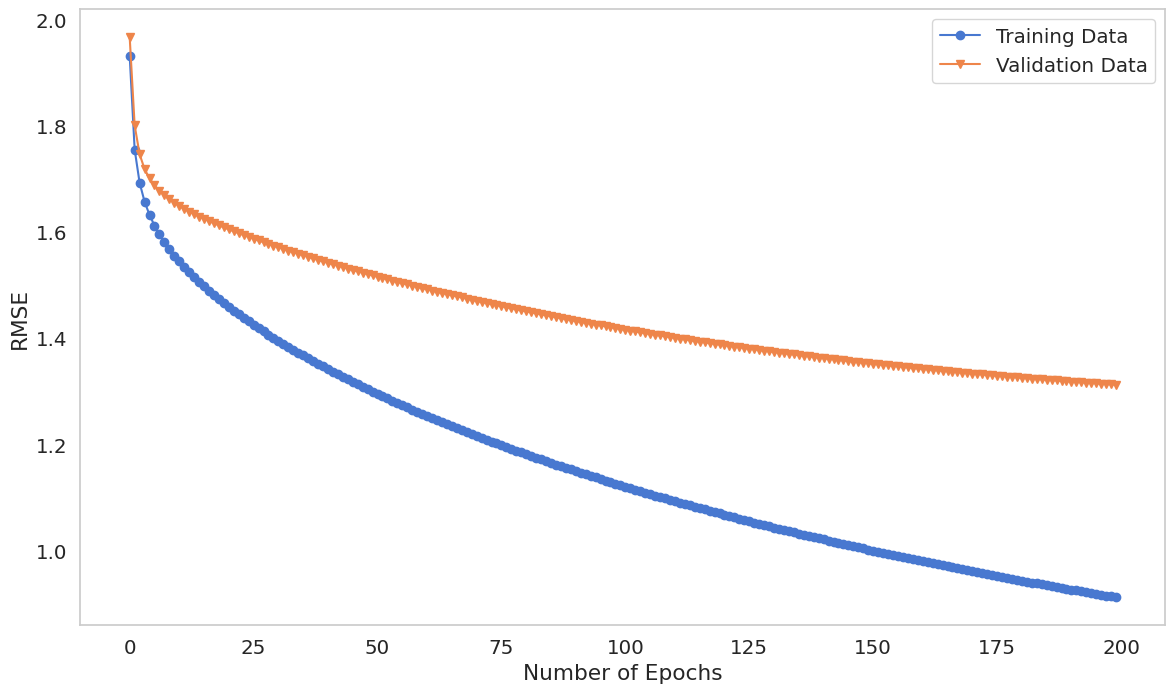

In [16]:
plt.plot(range(recommender.n_epochs), recommender.train_error, marker='o', label='Training Data');
plt.plot(range(recommender.n_epochs), recommender.val_error, marker='v', label='Validation Data');
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()